<a href="https://colab.research.google.com/github/pmckim1/NLP_News_Project/blob/main/News_LDA_FULL_DATASET_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:

!pip install pyLDAvis
!pip install gensim --upgrade
! pip show gensim


Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.3)
Name: gensim
Version: 3.8.3
Summary: Python framework for fast Vector Space Modelling
Home-page: http://radimrehurek.com/gensim
Author: Radim Rehurek
Author-email: me@radimrehurek.com
License: LGPLv2.1
Location: /usr/local/lib/python3.6/dist-packages
Requires: scipy, smart-open, numpy, six
Required-by: 


# Creating an LDA model of News Articles using gensim + pyLDAvis 




In [28]:
import gensim
import re
import random
import pyLDAvis

import numpy as np
import pandas as pd
import seaborn as sns
import pyLDAvis.gensim as gensimvis

from gensim.models.ldamulticore import LdaMulticore

from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
from nltk.stem import SnowballStemmer
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.model_selection import train_test_split


import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
#define lemmatizer for later 
wordnet_lemmatizer = WordNetLemmatizer()
%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [29]:
from google.colab import drive
import sys
import pandas as pd
# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/nlpproj/'

#data_set = pd.read_csv(abspath_curr + 'Guardian.csv')
datanews = pd.read_csv(abspath_curr +'combined_news.csv', header=0)
#datanews= data_set["text"]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.  Data exploration

In [30]:
len(datanews)

3073

In [31]:
len(pd.unique(datanews['text']))

3072

In [32]:
list(datanews)

['article number',
 'headline',
 'webPublicationDate',
 'text',
 'snippet',
 'section',
 'source',
 'week',
 'Unnamed: 8']

In [33]:
datanews[["headline", "webPublicationDate", "text", "source"]].head()

,headline,webPublicationDate,text,source
0,Doubts on Mail Prompt a Push To Vote on Site,2020-10-01,"In Philadelphia, officials are encouraging vot...",NYT
1,Trump Plays Victim As Debate and Polls Pour on...,2020-10-01,"Be it congressional Democrats, the news media,...",NYT
2,In my dreams I'm there': the exodus from Hong ...,2020-10-01,Joe Kwong* loves Hong Kong. But he knows he ha...,Guardian
3,On a knife-edge': NHS frontline prepares for a...,2020-10-01,“At the moment it feels like we are on a knife...,Guardian
4,Activists criticise 'tokenistic' efforts after...,2020-10-01,Tokenistic gestures are being made in place of...,Guardian


## 2.  Data Preparation

In [34]:
# A quick utility function to pre-process the text using lemmitization 
def preprocess_desc(description):
    return( [wordnet_lemmatizer.lemmatize(token) for token in simple_preprocess(str(description)) if token not in STOPWORDS] )

In [35]:
# NB;  This step could be improved through first filtering to words that are pronouns.
datanews['tokens'] = datanews['text'].apply(preprocess_desc)

In [36]:
datanews[["headline", "webPublicationDate", "text", "source", "tokens"]].tail()

,headline,webPublicationDate,text,source,tokens
3068,Keir Starmer forced to self-isolate after staf...,2020-12-05,Keir Starmer has been forced to self-isolate f...,Guardian,"[keir, starmer, forced, self, isolate, second,..."
3069,Nathan Law: 'No one knows when I can go back t...,2020-12-05,Nathan Law began 2020 planning a new run for o...,Guardian,"[nathan, law, began, planning, new, run, offic..."
3070,NHS test and trace adviser defends mass use of...,2020-12-05,The mass use of rapid coronavirus tests has be...,Guardian,"[mass, use, rapid, coronavirus, test, defended..."
3071,Robert Jenrick controversy was factor in ethic...,2020-12-05,Boris Johnson’s failure to authorise an inquir...,Guardian,"[boris, johnson, failure, authorise, inquiry, ..."
3072,Team behind Oxford Covid jab start final stage...,2020-12-05,The Oxford team that has produced a successful...,Guardian,"[oxford, team, produced, successful, coronavir..."


## 3. Create TF-IDF representation

In [37]:
# Create the vocabulary record
dictionary = gensim.corpora.Dictionary(datanews['tokens'])

In [38]:
# Remove extreme values (words that are too rare, too common)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

In [39]:
# Create a BOW model
bow_corpus = [dictionary.doc2bow(doc) for doc in datanews['tokens']]

In [40]:
# From that create the TF-IDF model
tfidf = gensim.models.TfidfModel(bow_corpus)
datanews['corpus_tfidf'] = tfidf[bow_corpus]

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [41]:
datanews['corpus_tfidf'].head()

0    [(0, 0.25703686530579617), (1, 0.1095165973476...
1    [(9, 0.09656521891241654), (12, 0.135810654117...
2    [(1, 0.010556655778350573), (5, 0.026718001990...
3    [(11, 0.014956936500472622), (26, 0.0148045105...
4    [(4, 0.4251633458042451), (66, 0.0224257414085...
Name: corpus_tfidf, dtype: object

## 4.  Create LDA models 
Train-test split only, because I'm not iteratively improving anything

In [42]:
random.seed(10)
trainset, testset = train_test_split(datanews, test_size=0.20)

In [43]:
# Loop through a number of different topic model sizes
# this cell is very slow!!! reduce range size to speed it up; we tested additional numbers in testing phase but reduce it here to improve run time  

results = pd.DataFrame()

for num_topics in range(30, 50):
    lda_model_tfidf = LdaMulticore(trainset['corpus_tfidf'],
                               num_topics=num_topics,
                               id2word=dictionary,
                               passes=2)
    
    # Get the perplexity
    perplexity = lda_model_tfidf.log_perplexity(testset['corpus_tfidf'])
    
    # Get the coherence
    cm = CoherenceModel(model=lda_model_tfidf, corpus=testset['corpus_tfidf'], coherence='u_mass')
    #try:
    coherence = cm.get_coherence()
    #except Exception as e:
      #print(e)
      #print("Error encountered in num_topics {}, skipping and conitnuing.".format(num_topics))
      #continue

    
    # record
    results = results.append({"topics":num_topics, "perplexity":perplexity, "coherence":coherence}, ignore_index=True)
    
    # Report for my convenience
    print("tried {} topics".format(num_topics), "perplexity = {}".format(perplexity), "coherence = {}".format(coherence))

results.to_csv("tested_lda_stats_clean.csv")





tried 30 topics perplexity = -28.000872488678556 coherence = -11.674301047857233


tried 31 topics perplexity = -28.15462463508525 coherence = -11.658264396728255


tried 32 topics perplexity = -28.895263711788864 coherence = -11.461975977880478


tried 33 topics perplexity = -29.15452347111103 coherence = -11.923540633449363


tried 34 topics perplexity = -30.22746837343528 coherence = -11.711138323375742


tried 35 topics perplexity = -30.503098091070935 coherence = -12.03059378716297


tried 36 topics perplexity = -31.094519605927115 coherence = -11.253337723865034


tried 37 topics perplexity = -31.44672716873058 coherence = -11.8658514808749


tried 38 topics perplexity = -32.10156219528313 coherence = -11.98401400994554


tried 39 topics perplexity = -32.210027356268874 coherence = -11.971297524165129


tried 40 topics perplexity = -32.55094862196764 coherence = -11.83965307781753


tried 41 topics perplexity = -33.23744817251644 coherence = -12.057966506860973


tried 42 topics perplexity = -33.67677530491022 coherence = -12.83919045414062


tried 43 topics perplexity = -33.89878967814212 coherence = -12.2102064155979


tried 44 topics perplexity = -34.397890920293804 coherence = -12.636748054975543


tried 45 topics perplexity = -34.666386816931386 coherence = -13.527616512651846


tried 46 topics perplexity = -35.32435155343467 coherence = -12.211387681610226


tried 47 topics perplexity = -35.83813296863851 coherence = -12.198780945574626


tried 48 topics perplexity = -36.25982109885439 coherence = -12.104044835200193
tried 49 topics perplexity = -36.567510137165584 coherence = -11.884762182648256


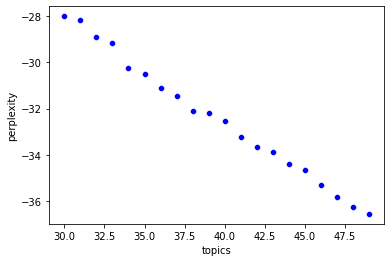

In [44]:
# plot the results
sns.scatterplot(x="topics", y="perplexity", color="blue", data=results)

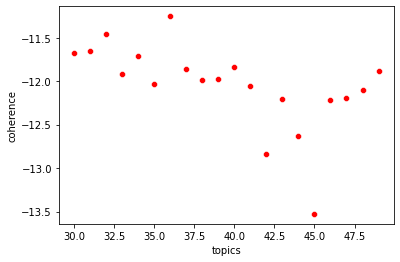

In [45]:
# plot the results
sns.scatterplot(x="topics", y="coherence", color="red", data=results)

## 5.  Create the "Best" Model for our purposes
We want smaller tighter clusters to achieve out goal of grouping together news stories about the same event, previous gaphs suggested 152 for num_topics will work well 

In [46]:
random.seed(10)

# Fit the final lda model to all data
lda_model_tfidf = LdaMulticore(datanews['corpus_tfidf'],
                           num_topics=152,
                           id2word=dictionary,
                           passes=2)

# Get the perplexity, out of curiosity
perplexity = lda_model_tfidf.log_perplexity(datanews['corpus_tfidf'])
    
# Get the coherence, out of curiosity
cm = CoherenceModel(model=lda_model_tfidf, corpus=datanews['corpus_tfidf'], coherence='u_mass')
coherence = cm.get_coherence()

print("perplexity = {}".format(perplexity), "coherence = {}".format(coherence))

perplexity = -53.413342390476096 coherence = -3.2430894978276497


In [47]:
# quick look at the topics picked out
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.005*"tier" + 0.004*"intolerable" + 0.004*"overwhelmed" + 0.004*"nh" + 0.003*"mitigate" + 0.003*"restriction" + 0.003*"disappointed" + 0.003*"mp" + 0.003*"cite" + 0.003*"document"
Topic: 1 Word: 0.001*"vaccination" + 0.001*"region" + 0.001*"farage" + 0.000*"separatist" + 0.000*"violence" + 0.000*"vaccine" + 0.000*"africa" + 0.000*"del" + 0.000*"english" + 0.000*"humanitarian"
Topic: 2 Word: 0.001*"cummings" + 0.001*"cain" + 0.001*"mp" + 0.001*"backbencher" + 0.001*"staff" + 0.000*"johnson" + 0.000*"research" + 0.000*"downing" + 0.000*"street" + 0.000*"adviser"
Topic: 3 Word: 0.017*"citizen" + 0.013*"convention" + 0.012*"assembly" + 0.006*"climate" + 0.006*"jaunes" + 0.006*"gilets" + 0.004*"learnt" + 0.003*"french" + 0.003*"say" + 0.003*"poverty"
Topic: 4 Word: 0.024*"tier" + 0.019*"testing" + 0.017*"county" + 0.015*"area" + 0.013*"virus" + 0.012*"quarantine" + 0.012*"test" + 0.012*"case" + 0.011*"trace" + 0.010*"rule"
Topic: 5 Word: 0.018*"travel" + 0.012*"store" + 0.01

## Create Visualization of resulting clusters (Interactive Graphs)

---



In [48]:
#create clusters using mmds method for multidemensional scaling 
vis_data = gensimvis.prepare(lda_model_tfidf, datanews['corpus_tfidf'], dictionary, mds='mmds') 

In [49]:
pyLDAvis.display(vis_data)

In [52]:
# Let's take a quick look at words the topics picked out
topic_word_dist = pd.DataFrame()

for idx, topic in lda_model_tfidf.print_topics(-1):
    
    # Record the topic index in a format R will like
    topic_index = "X" + str(idx)
    
    # Record the topic's key words as a single string
    # Split the words with a newline character while we're at it!
    topic_words = " ".join([x.split("*")[1].replace('"', '').strip() for x in topic.split("+")][0:5])
    
    # Dump them to the results dataframe
    topic_word_dist = topic_word_dist.append({"topic":topic_index, "keywords":topic_words}, ignore_index=True)

In [55]:
topic_word_dist

,keywords,topic
0,tier intolerable overwhelmed nh mitigate,X0
1,vaccination region farage separatist violence,X1
2,cummings cain mp backbencher staff,X2
3,citizen convention assembly climate jaunes,X3
4,tier testing county area virus,X4
...,...,...
147,zealand ardern game refugee muslim,X147
148,police violence village force group,X148
149,sunak hancock error ashworth contact,X149
150,cummings wind departure walking shop,X150
